# 롱-숏 전략. 6부 집라인을 사용한 백테스트

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb) : we predict returns for our out-of-sample period 2017.
6. `backtesting_with_zipline` (this noteboook): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!wget https://artiya4u.keybase.pub/TA-lib/ta-lib-0.4.0-src.tar.gz &&tar -xvf ta-lib-0.4.0-src.tar.gz &&cd ta-lib/ &&./configure --prefix=/usr &&make &&sudo make install

--2021-12-07 12:52:25--  https://artiya4u.keybase.pub/TA-lib/ta-lib-0.4.0-src.tar.gz
Resolving artiya4u.keybase.pub (artiya4u.keybase.pub)... 35.173.156.66, 34.237.172.94, 54.152.69.160
Connecting to artiya4u.keybase.pub (artiya4u.keybase.pub)|35.173.156.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1330299 (1.3M) [application/gzip]
Saving to: ‘ta-lib-0.4.0-src.tar.gz.2’

ta-lib-0.4.0-src.ta 100%[===================>]   1.27M  --.-KB/s    in 0.1s    

2021-12-07 12:52:25 (8.82 MB/s) - ‘ta-lib-0.4.0-src.tar.gz.2’ saved [1330299/1330299]

ta-lib/
ta-lib/config.sub
ta-lib/aclocal.m4
ta-lib/CHANGELOG.TXT
ta-lib/include/
ta-lib/include/ta_abstract.h
ta-lib/include/ta_func.h
ta-lib/include/ta_common.h
ta-lib/include/ta_config.h.in
ta-lib/include/Makefile.am
ta-lib/include/ta_libc.h
ta-lib/include/ta_defs.h
ta-lib/missing
ta-lib/ta-lib.spec.in
ta-lib/config.guess
ta-lib/Makefile.in
ta-lib/ta-lib.dpkg.in
ta-lib/Makefile.am
ta-lib/autogen.sh
ta-lib/install-sh
ta-l

In [3]:
!pip install --upgrade zipline-reloaded pyfolio-reloaded tables

In [4]:
!cp -r "/content/drive/MyDrive/금융특화 AI 역량강화교육 - 증권 (심화) -/.zipline" "/root"

## Imports & Settings

In [5]:
from collections import defaultdict
from time import time
import warnings
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO, WARNING

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader
from trading_calendars import get_calendar

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [6]:
os.chdir('/content/drive/MyDrive/금융특화 AI 역량강화교육 - 증권 (심화) -/12_gradient_boosting_machines')

In [ ]:
# optional; not pre-installed; see above
# import seaborn as sns
# sns.set_style('darkgrid')

In [7]:
warnings.filterwarnings('ignore')
np.random.seed(42)

### 집라인 익스텐션 로딩(Load zipline extensions)

다음은 노트북에서 번들을 찾을 때만 필요하다. (Only need this in notebook to find bundle.)

In [ ]:
# os.environ['ZIPLINE_ROOT'] = 'C:/Users/PC/.zipline/'

In [ ]:
# load_extensions(default=True,
#                 extensions=[],
#                 strict=True,
#                 environ=None)

In [8]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=WARNING)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [9]:
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 20

## 데이터 로딩

### 퀀들 위키 번들 (Quandl Wiki Bundle)

zipline ingest를 실행해야 한다(설치 지침 및 8장 참조). Quandl에서 데이터를 직접 다운로드할 때는 QUANDL API KEY를 제공할 필요가 있지만, 여기서는 이미 데이터를 다운로드했으므로 필요가 없다.

In [ ]:
# !zipline ingest

[2021-12-07 12:31:13.643405] INFO: zipline.data.bundles.core: Ingesting quandl.
Traceback (most recent call last):
  File "/usr/local/bin/zipline", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 829, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 782, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 1259, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 1066, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 610, in invoke
    return callback(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/zipline/__main__.py", line 394, in ingest
    show_progress,
  File "/usr/local/lib/python3.7/dist-packages/zipline/data/bundles/core.p

In [10]:
bundle_data = bundles.load('quandl')

ValueError: ignored

In [11]:
!zipline ingest -b quandl

[2021-12-07 12:54:32.592094] INFO: zipline.data.bundles.core: Ingesting quandl.
Traceback (most recent call last):
  File "/usr/local/bin/zipline", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 829, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 782, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 1259, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 1066, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 610, in invoke
    return callback(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/zipline/__main__.py", line 394, in ingest
    show_progress,
  File "/usr/local/lib/python3.7/dist-packages/zipline/data/bundles/core.p

### ML 예측

예측치를 읽는데 문제가 발생하면 다음을 실행해 ([source](https://stackoverflow.com/questions/54210073/pd-read-hdf-throws-cannot-set-writable-flag-to-true-of-this-array)))를 업그레이드한다.

In [ ]:
def load_predictions(bundle):
    predictions = (pd.read_hdf('data/predictions.h5', 'lgb/train/01')
                   .append(pd.read_hdf('data/predictions.h5', 'lgb/test/01').drop('y_test', axis=1)))
    predictions = (predictions.loc[~predictions.index.duplicated()]
                   .iloc[:, :10]
                   .mean(1)
                   .sort_index()
                   .dropna()
                  .to_frame('prediction'))
    tickers = predictions.index.get_level_values('symbol').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('symbol')
            .rename(columns=ticker_map)
            .prediction
            .tz_localize('UTC')), assets

In [ ]:
predictions, assets = load_predictions(bundle_data)

In [ ]:
predictions

symbol,0,2,4,7,8,13,14,18,19,20,24,30,34,36,37,44,45,48,49,52,53,54,61,64,65,66,67,70,71,75,77,79,80,85,86,87,93,98,105,106,...,2789,2794,2797,2805,2807,2812,2813,2815,2822,2830,2836,2837,2838,2840,2845,2846,2848,2849,2851,2852,2857,2861,2862,2863,2868,2870,2872,2878,2881,2889,2896,2897,2898,2901,2905,2907,2913,2914,2915,2919
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00+00:00,-0.009341,-0.006678,-0.008685,-0.010557,-0.012085,-0.004211,-0.010041,-0.008795,-0.006689,-0.009923,-0.004387,-0.007916,-0.013331,-0.011172,-0.008586,-0.015164,-0.010111,-0.010641,-0.012535,-0.008211,-0.010527,-0.007513,-0.013034,-0.005803,-0.010360,-0.008158,-0.008573,-0.014092,-0.009008,-0.007127,-0.005670,-0.018433,-0.010396,-0.011908,-0.005785,-0.006614,-0.008036,-0.003733,-0.008934,-0.008655,...,-0.011270,-0.015715,-0.010484,-0.010611,-0.008627,-0.010283,-0.010763,-0.001425,-0.007165,-0.009354,-0.003717,-0.007311,-0.012296,-0.009290,-0.009493,-0.008394,-0.007032,-0.007044,-0.009855,-0.006013,-0.007549,-0.007784,-0.005542,-0.014885,-0.003911,-0.008773,-0.006352,-0.008852,-0.010033,-0.007463,-0.007903,-0.010036,-0.010198,-0.012196,-0.014234,-0.010993,-0.008714,-0.010871,-0.010811,-0.008084
2015-01-05 00:00:00+00:00,0.010692,0.016227,0.009231,0.010116,0.008098,0.010847,0.007660,0.007444,0.013837,0.004658,0.007364,0.008435,0.008254,0.010304,0.012754,0.014617,0.007965,0.013581,0.011555,0.007924,0.009490,0.009965,0.006340,0.017756,0.011710,0.015241,0.008866,0.011426,0.009197,0.011328,0.010011,0.013425,0.008348,0.007109,0.007182,0.010893,0.009846,0.009192,0.008089,0.007153,...,0.010796,0.006845,0.008883,0.007091,0.012549,0.008300,0.007711,0.013890,0.008034,0.010457,0.015790,0.013339,0.023313,0.007300,0.013406,0.008876,0.027128,0.008182,0.008991,0.010276,0.010007,0.013877,0.026565,0.010758,0.010144,0.011766,0.006843,0.011814,0.007705,0.007290,0.010151,0.009640,0.011448,0.011905,0.012114,0.009032,0.010565,0.008553,0.009758,0.006248
2015-01-06 00:00:00+00:00,0.002138,0.003576,0.004509,0.003501,-0.003307,0.003081,0.001612,0.005378,0.005040,-0.001427,0.005145,0.001812,-0.000475,0.003610,0.003636,-0.001380,0.001656,0.005345,-0.002089,0.003275,0.003136,0.002682,0.000956,0.006102,0.002559,0.004391,0.000032,0.000657,0.000045,0.001531,0.001143,0.003174,-0.000510,0.001485,-0.001265,0.003002,-0.000924,-0.001517,-0.000145,0.007789,...,0.003490,-0.000104,-0.001373,0.000078,0.001087,-0.001256,-0.002063,0.003853,0.003037,0.001442,0.009933,0.002621,0.016351,0.000388,0.003729,-0.000792,0.012429,0.004367,0.000212,0.002541,-0.000502,0.001785,0.010536,-0.001426,0.006334,0.000046,-0.001412,0.006402,-0.000275,0.004179,0.003733,0.003814,0.001827,0.003349,0.000469,0.000495,-0.000432,0.002711,0.001500,0.006297
2015-01-07 00:00:00+00:00,-0.000253,-0.004159,-0.006198,-0.006150,-0.004869,-0.005375,0.004357,-0.002480,0.006237,-0.006631,-0.003482,-0.003745,-0.008343,-0.001710,-0.002572,-0.004034,-0.003244,-0.003881,-0.004882,-0.006371,-0.006173,0.000424,-0.008144,0.005307,-0.002043,-0.002892,-0.006369,0.001390,-0.002795,-0.005176,-0.000388,-0.013337,-0.002774,-0.004540,-0.004319,-0.001648,-0.002993,-0.003866,0.000193,-0.004765,...,0.000233,-0.004933,-0.008394,-0.007296,-0.001549,-0.002605,-0.005839,0.001714,-0.000907,-0.001492,0.003667,0.003439,0.009629,-0.004290,0.002682,-0.003690,0.010033,-0.003887,-0.005667,0.003742,-0.005721,-0.005627,0.005525,-0.007366,-0.003434,-0.003733,-0.001760,-0.001357,-0.004045,-0.004741,-0.002888,-0.005149,-0.002438,-0.008787,-0.008120,-0.010504,0.001126,-0.005285,-0.001178,-0.004693
2015-01-08 00:00:00+00:00,-0.003486,-0.010299,-0.007319,-0.007528,-0.007233,-0.005640,-0.006623,-0.005636,-0.001070,-0.005744,-0.002763,-0.002777,-0.009356,-0.001250,-0.004842,-0.008259,-0.004188,-0.006209,-0.010225,-0.004767,-0.005066,-0.004858,-0.010085,-0.003795,-0.007432,-0.013496,-0.006606,-0.009575,-0.001331,-0.003388,-0.004254,-0.017871,-0.004940,-0.006174,-0.003369,-0.003155,-0.005731,-0.006814,-0.006954,-0.005

In [ ]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2015-01-02 00:00:00+00:00 to 2017-12-28 00:00:00+00:00
Columns: 993 entries, 0 to 2919
dtypes: float64(993)
memory usage: 5.7 MB


### 맞춤형 데이터 세트 정의

In [ ]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

###파이프라인 로더(Pipeline Loaders)의 정의

In [ ]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

## 파이프라인 설정(Pipeline Setup)

### 맞춤형 ML 팩터 (Custom ML Factor)

In [ ]:
class MLSignal(CustomFactor):
    """시그널을 팩터로 변환해서
       파이프라인에서 순위 매기기(rank)와 필터링(filter) 할 수 있도록 한다."""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, predictions):
        out[:] = predictions

### 파이프라인 작성(Create Pipeline)

In [ ]:
def compute_signals():
    signals = MLSignal()
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
            screen=StaticAssets(assets))

## 알고리듬 초기화(Initialize Algorithm)

In [ ]:
def initialize(context):
    """
    알고리듬 초기에 한번만 호출.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()
    context.longs = context.shorts = 0
    
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.001, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
#                       date_rules.week_start(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### 일별 파이프라인 결과 (Get daily Pipeline results)

In [ ]:
def before_trading_start(context, data):
    """
    시장 열리기 전에 매일 호출.
    """
    output = pipeline_output('signals')
    df = (output['longs'].astype(int)
                      .append(output['shorts'].astype(int).mul(-1)))
    
    holdings = df[df!=0]
    other = df[df==0]
    other = other[~other.index.isin(holdings.index) & ~other.index.duplicated()]
    context.trades = holdings.append(other)
    assert len(context.trades.index.unique()) == len(context.trades)

## 리밸런싱 로직의 정의 (Define Rebalancing Logic)

In [ ]:
def rebalance(context, data):
    """
    schedule_function()의 날짜와 시간 규칙에 따라 실행
    (Execute orders according to schedule_function() date & time rules.)
    """
    trades = defaultdict(list)
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    positions = context.portfolio.positions
    s=pd.Series({s:v.amount*v.last_sale_price for s, v in positions.items()}).sort_values(ascending=False)
    for stock, trade in context.trades.items():
        if trade == 0:
            order_target(stock, target=0)
        else:
            trades[trade].append(stock)
    
    context.longs, context.shorts = len(trades[1]), len(trades[-1])
#     log.warning('{} {:,.0f}'.format(len(positions), context.portfolio.portfolio_value))
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)
    else:
        for stock in trades[-1] + trades[1]:
            if stock in positions:
                order_target(stock, 0)

## 데이터 포인트 기로 (Record Data Points)

In [ ]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## 알고리듬 실행 (Run Algorithm)

(표본내) 검증과 표본외 테스트 기간에 대해 전략 (We backtest our strategy during the (in-sample) validation and out-of-sample test period)

In [ ]:
dates = predictions.index.get_level_values('date')
start_date, end_date = dates.min(), dates.max()  #+ pd.Timedelta(-30, 'D')

In [ ]:
print('Start: {}\nEnd:   {}'.format(start_date.date(), end_date.date()))

Start: 2015-01-02
End:   2017-11-28


In [ ]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e5,
                        data_frequency='daily',
                        bundle='quandl',
                        custom_loader=signal_loader)  # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

Duration: 121.80s


## 파이폴리오 분석 (PyFolio Analysis)

표본외 성과를 시각화하기 위해 '2017-01-01'을 'live_start-date'의 시작일로 전달한다. 

In [ ]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [ ]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

### 사용자 정의 그래프(Custom Plots)

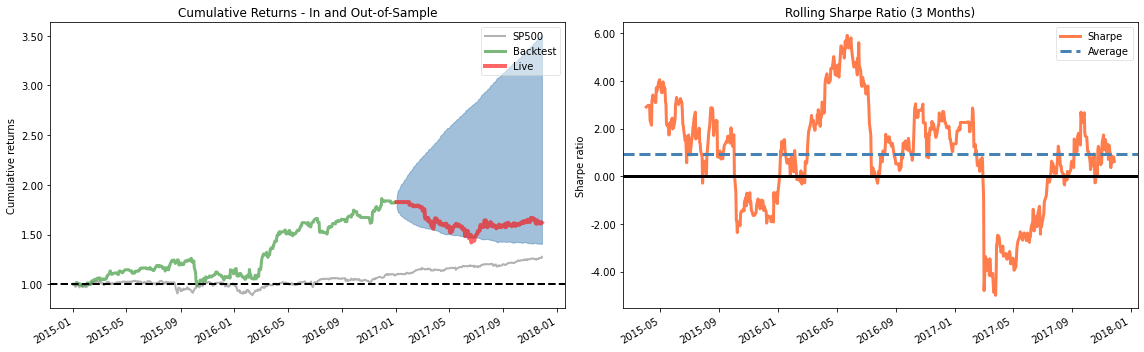

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date='2017-01-01',
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout();

### 테어시트(Tear Sheets)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.72,2016-11-30,2017-06-21,NaT,NaN
1,21.70,2015-09-25,2015-10-08,2016-03-04,116
2,9.45,2016-07-06,2016-07-29,2016-09-13,50
3,7.57,2016-09-27,2016-11-04,2016-11-15,36
4,4.75,2015-07-10,2015-07-28,2015-08-10,22


Top 10 long positions of all time,max
sid,
HRTX,6.41%
ALNY,6.00%
CLF,5.43%
EXAS,5.20%
DNR,5.14%
SM,5.12%
TECD,5.08%
SGMS,5.07%
STMP,5.06%


Top 10 short positions of all time,max
sid,
CHK,-5.46%
BECN,-5.28%
ATHN,-5.25%
STX,-5.17%
DNR,-5.12%
CLF,-5.09%
SM,-5.01%
MAT,-4.87%
ALGN,-4.87%


Top 10 positions of all time,max
sid,
HRTX,6.41%
ALNY,6.00%
CHK,5.46%
CLF,5.43%
BECN,5.28%
ATHN,5.25%
EXAS,5.20%
STX,5.17%
DNR,5.14%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,22577.00,11563.00,11014.00
Percent profitable,0.50,0.48,0.52
Winning round_trips,11258.00,5502.00,5756.00
Losing round_trips,11051.00,5927.00,5124.00
Even round_trips,268.00,134.00,134.00


PnL stats,All trades,Short trades,Long trades
Total profit,$172735.98,$-31498.53,$204234.51
Gross profit,$1288933.82,$523363.86,$765569.96
Gross loss,$-1116197.84,$-554862.39,$-561335.45
Profit factor,$1.15,$0.94,$1.36
Avg. trade net profit,$7.65,$-2.72,$18.54
Avg. winning trade,$114.49,$95.12,$133.00
Avg. losing trade,$-101.00,$-93.62,$-109.55
Ratio Avg. Win:Avg. Loss,$1.13,$1.02,$1.21
Largest winning trade,$11069.40,$5272.20,$11069.40
Largest losing trade,$-4809.95,$-1978.82,$-4809.95


Duration stats,All trades,Short trades,Long trades
Avg duration,1 days 22:43:12.567214421,1 days 18:30:52.770993686,2 days 03:08:07.016433629
Median duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00
Longest duration,216 days 04:00:01,216 days 04:00:01,216 days 04:00:01
Shortest duration,0 days 03:00:01,0 days 03:00:01,0 days 03:00:01


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.01%,0.01%,0.01%
Avg returns winning,0.08%,0.08%,0.08%
Avg returns losing,-0.07%,-0.07%,-0.07%
Median returns all round_trips,0.00%,0.00%,0.00%
Median returns winning,0.04%,0.04%,0.04%
Median returns losing,-0.04%,-0.04%,-0.04%
Largest winning trade,7.00%,7.00%,4.33%
Largest losing trade,-2.98%,-2.98%,-1.28%


Symbol stats,A,AAL,AAN,AAP,AAPL,ABC,ABCB,ABM,ABMD,ABT,ACC,ACGL,ACIW,ACM,ACN,ACXM,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEIS,AEL,AEO,AEP,AES,AET,AFG,AFL,AFSI,AGCO,AGN,AGNC,AGO,AHL,AIG,AIT,AIV,AIZ,AJG,AKAM,AKR,AKRX,ALB,ALE,ALGN,ALGT,ALK,ALKS,ALL,ALNY,ALX,ALXN,AMAT,AMD,AME,AMED,AMG,AMGN,AMKR,AMP,AMT,AMTD,AMZN,AN,ANAT,ANSS,ANTM,AON,AOS,APA,APC,APD,APH,ARE,ARI,ARNA,ARNC,ARRS,ARRY,ARW,ASGN,ASH,ATHN,ATI,ATO,ATR,ATVI,AVA,AVB,AVGO,AVT,AVX,AVY,AWI,AWK,AWR,AXE,AXP,AXS,AYI,AZO,AZPN,B,BA,BAC,BAH,BANF,BANR,BAX,BBBY,BBT,BBY,BC,BCO,BCPC,BDC,BDN,BDX,BECN,BEN,BG,BGCP,BGS,BID,BIDU,BIIB,BIO,BK,BKH,BLDR,BLK,BLKB,BLL,BMRN,BMS,BMY,BOFI,BOH,BOKF,BP,BPOP,BR,BRC,BRKR,BRKS,BRO,BSX,BWA,BXP,BXS,BYD,C,CA,CACC,CACI,CAG,CAH,CAKE,CALM,CAR,CASY,CAT,CATY,CAVM,CB,CBOE,CBRL,CBSH,CBT,CBU,CCE,CCI,CCK,CCL,CCMP,CCOI,CDNS,CE,CELG,CENTA,CERN,CF,CFR,CFX,CGNX,CHD,CHDN,CHE,CHFC,CHH,CHK,CHKP,CHRW,CHSP,CHTR,CI,CIEN,CIM,CINF,CIT,CL,CLF,CLGX,CLH,CLNY,CLR,CLX,CMA,CMC,CMCSA,CME,CMG,CMI,CMP,CMS,CNA,CNC,CNK,CNMD,CNO,CNP,CNS,CNX,COF,COG,COHR,COL,COLB,COLM,COO,COP,COR,COST,CPA,CPB,CPE,CPRT,CPS,CPT,CR,CREE,CRI,CRL,CRM,CRS,CRUS,CRZO,CSCO,CSFL,CSGP,CSL,CSX,CTAS,CTL,CTSH,CTXS,CUBE,CUZ,CVA,CVBF,CVG,CVI,CVLT,CVS,CVX,CW,CWT,CXO,CXW,CY,D,DAL,DAN,DAR,DCI,DCT,DDS,DE,DECK,DEI,DFS,DG,DGX,DHI,DHR,DIS,DISCA,DISCK,DISH,DK,DKS,DLB,DLR,DLTR,DLX,DNB,DNR,DO,DOOR,DORM,DOV,DOX,DPS,DPZ,DRE,DRH,DRI,DRQ,DSW,DTE,DUK,DVA,DVN,DXCM,DY,EA,EAT,EBAY,EBIX,EBS,ECL,ED,EDR,EE,EEFT,EFX,EGBN,EGHT,EGN,EGP,EIX,EL,ELS,EME,EMN,EMR,ENDP,ENR,ENS,ENSG,ENTG,ENV,EOG,EPAY,EPR,EQIX,EQR,EQT,ERIE,ES,ESGR,ESL,ESRX,ESS,ESV,ETFC,ETN,ETR,EV,EVR,EW,EWBC,EXAS,EXC,EXEL,EXLS,EXP,EXPD,EXPE,EXPO,EXR,F,FAF,FAST,FBC,FCFS,FCN,FCNCA,FCX,FDP,FDS,FDX,FE,FELE,FFBC,FFG,FFIN,FFIV,FHN,FIBK,FICO,FII,FIS,FISV,FITB,FIZZ,FL,FLIR,FLO,FLR,FLS,FLT,FMBI,FMC,FNB,FNF,FNGN,FNSR,FOLD,FOX,FOXA,FR,FRME,FRT,FSLR,FTI,FTNT,FUL,FULT,G,GBCI,GD,GDOT,GE,GEO,GGG,GGP,GHC,GIII,GILD,GIS,GLNG,GLW,GM,GNRC,GNTX,GNW,GOLD,GOOGL,GPC,GPK,GPN,GPOR,GPS,GPT,GRA,GRMN,GS,GT,GTLS,GTT,GVA,GWR,GWW,H,HAE,HAIN,HAL,HALO,HAS,HBAN,HBI,HCP,HCSG,HD,HE,HEI,HELE,HES,HFC,HHC,HI,HIG,HIW,HLF,HOG,HOLX,HOMB,HON,HP,HPP,HPQ,HPT,HR,HRB,HRC,HRG,HRL,HRS,HRTX,HSIC,HST,HSY,HTH,HTLF,HUM,HUN,HXL,IART,IBKC,IBKR,IBM,IBOC,ICE,ICUI,IDA,IDCC,IDTI,IDXX,IEX,IFF,IGT,IIVI,ILMN,IMMU,INCY,INDB,INGR,INTC,INTU,IP,IPG,IPGP,IR,IRBT,IRM,IRWD,ISBC,ISCA,ISRG,IT,ITRI,ITT,ITW,IVZ,JACK,JBHT,JBL,JBLU,JBT,JCI,JCOM,JEC,JJSF,JKHY,JLL,JNJ,JNPR,JPM,JWN,K,KAR,KBH,KBR,KEX,KEY,KFY,KIM,KLAC,KMB,KMPR,KMT,KMX,KNX,KO,KR,KRC,KRO,KS,KSS,KSU,KW,KWR,L,LAD,LAMR,LANC,LAZ,LB,LBTYA,LDOS,LEA,LECO,LEG,LEN,LFUS,LGND,LH,LHCG,LHO,LII,LKQ,LLL,LLY,LM,LMT,LNC,LNG,LNT,LOGM,LOPE,LOW,LPLA,LPNT,LPX,LRCX,LSI,LSTR,LUV,LVS,LYB,LYV,M,MA,MAA,MAC,MAN,MANH,MANT,MAR,MAS,MASI,MAT,MATW,MBFI,MCD,MCHP,MCK,MCO,MCY,MD,MDCO,MDLZ,MDP,MDR,MDRX,MDSO,MDT,MDU,MET,MFA,MGEE,MGLN,MGM,MHK,MIDD,MINI,MKC,MKL,MKSI,MKTX,MLHR,MLM,MMC,MMM,MMS,MMSI,MNRO,MNST,MO,MOH,MORN,MOS,MPW,MPWR,MRK,MRO,MRVL,MS,MSA,MSCI,MSFT,MSG,MSI,MSM,MTB,MTD,MTG,MTN,MTX,MTZ,MU,MUR,MXIM,MYGN,MYL,NATI,NAV,NBIX,NBL,NBR,NCR,NDAQ,NDSN,NEE,NEM,NEOG,NEU,NFG,NFLX,NFX,NHI,NI,NJR,NKE,NKTR,NLY,NNI,NOC,NOV,NRG,NSC,NSP,NTAP,NTCT,NTGR,NTRS,NUAN,NUE,NUS,NUVA,NVDA,NVR,NWE,NWL,NXST,NYCB,NYT,O,OAS,OC,ODFL,OFC,OGE,OHI,OI,OII,OKE,OLED,OLN,OMC,OMCL,ONB,OPK,ORA,ORCL,ORI,ORLY,OSK,OTTR,OXY,OZRK,PACW,PAG,PAY,PAYX,PB,PBCT,PBH,PCAR,PCG,PCH,PDCE,PDCO,PDM,PEB,PEG,PEGA,PENN,PEP,PFE,PFG,PG,PGR,PH,PHM,PII,PKG,PKI,PLCE,PLD,PLT,PLXS,PM,PNC,PNFP,PNK,PNM,PNR,PNW,PODD,POL,POOL,POR,POWI,PPC,PPG,PPL,PRGO,PRI,PRU,PSA,PSB,PSMT,PTEN,PVH,PWR,PX,PXD,QCOM,QDEL,QGEN,R,RBC,RCL,RDC,RDN,RE,REG,REGN,RES,RF,RGEN,RGLD,RHI,RHP,RHT,RIG,RJF,RL,RLI,RMD,RNR,RNST,ROG,ROIC,ROK,ROL,ROLL,ROP,ROST,RP,RPM,RRC,RS,RSG,RTN,RYN,S,SAFM,SAIA,SAM,SANM,SATS,SBAC,SBGI,SBNY,SBRA,SBUX,SCCO,SCG,SCHW,SCI,SE,SEB,SEE,SEIC,SEM,SEMG,SF,SFLY,SFNC,SGEN,SGMS,SHO,SHOO,SHW,SIG,SIGI,SIRI,SIVB,SIX,SJI,SJM,SKT,SKX,SKYW,SLAB,SLB,SLG,SLGN,SLM,SM,SMG,SMTC,SNA,SNH,SNV,SNX,SO,SON,SPG,SPPI,SPR,SRCL,SRE,SSD,SSNC,STE,STI,STL,STLD,STMP,STT,STWD,STX,STZ,SUI,SWK,SWKS,SWN,SWX,SXT,SYK,SYMC,SYNT,SYY,T,TAL,TAP,TCBI,TCO,TDC,TDG,TDS

Profitability (PnL / PnL total) per name,
symbol,
ARNA,58.97%
SPPI,3.57%
ARRY,3.15%
AKRX,3.15%
DNR,3.02%
SWN,2.97%
ALNY,2.19%
GLNG,1.80%
ESV,1.76%


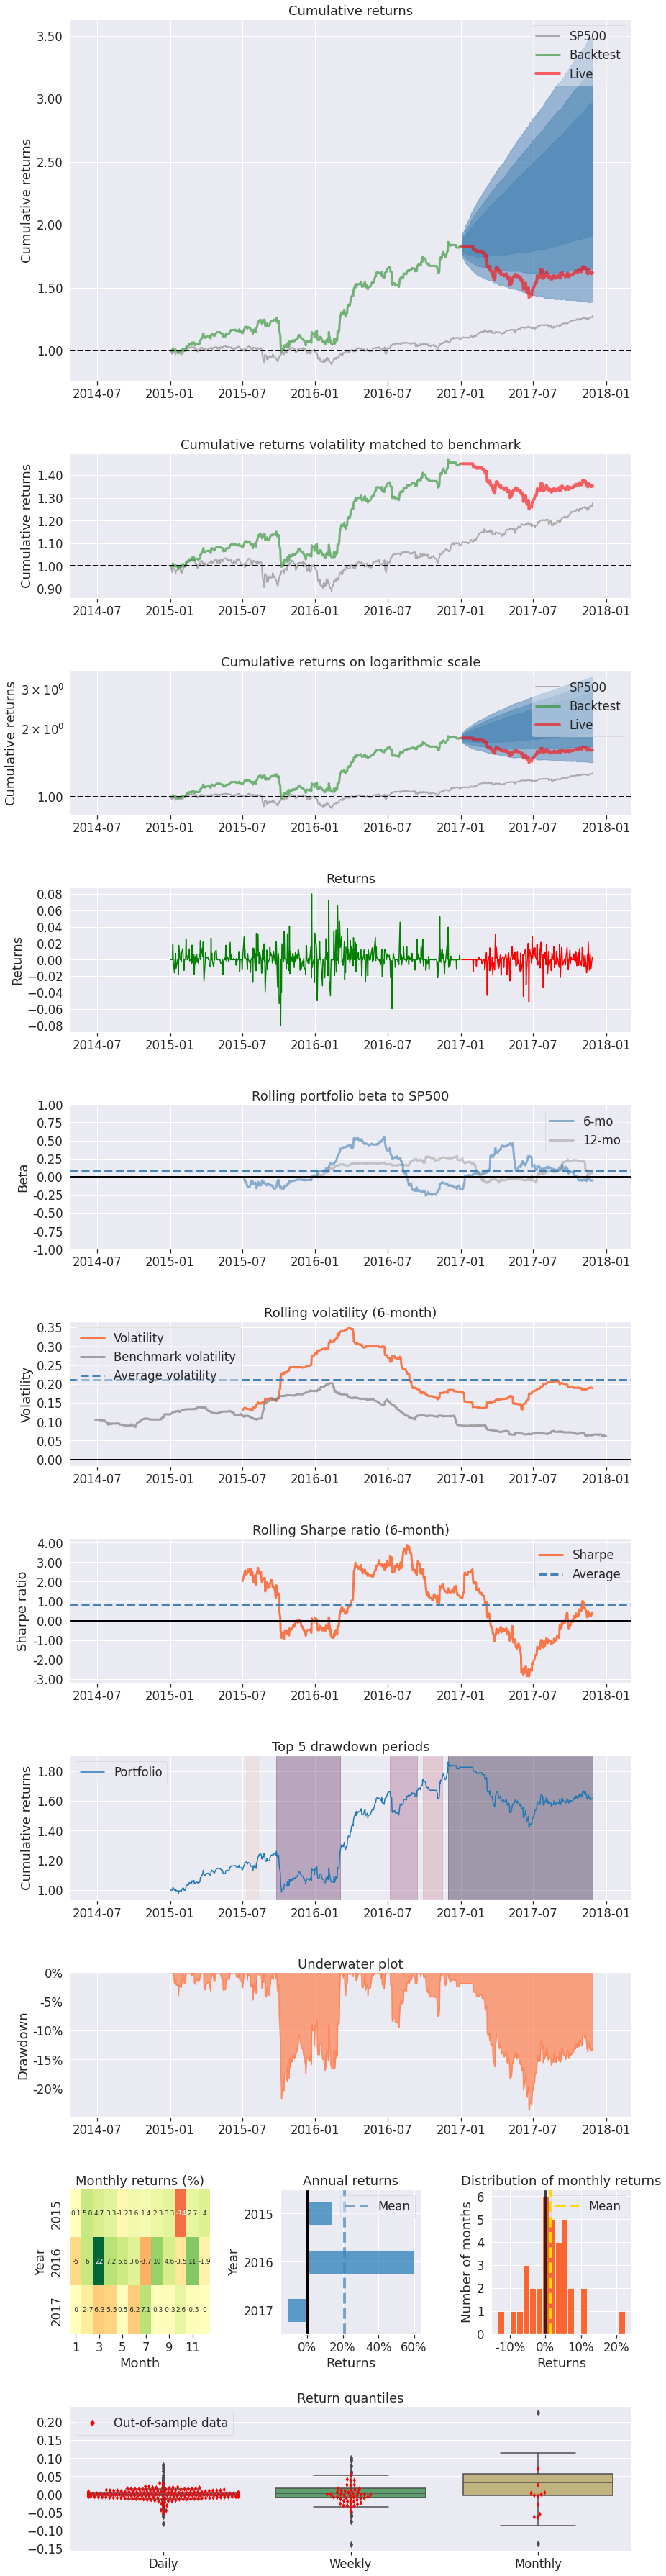

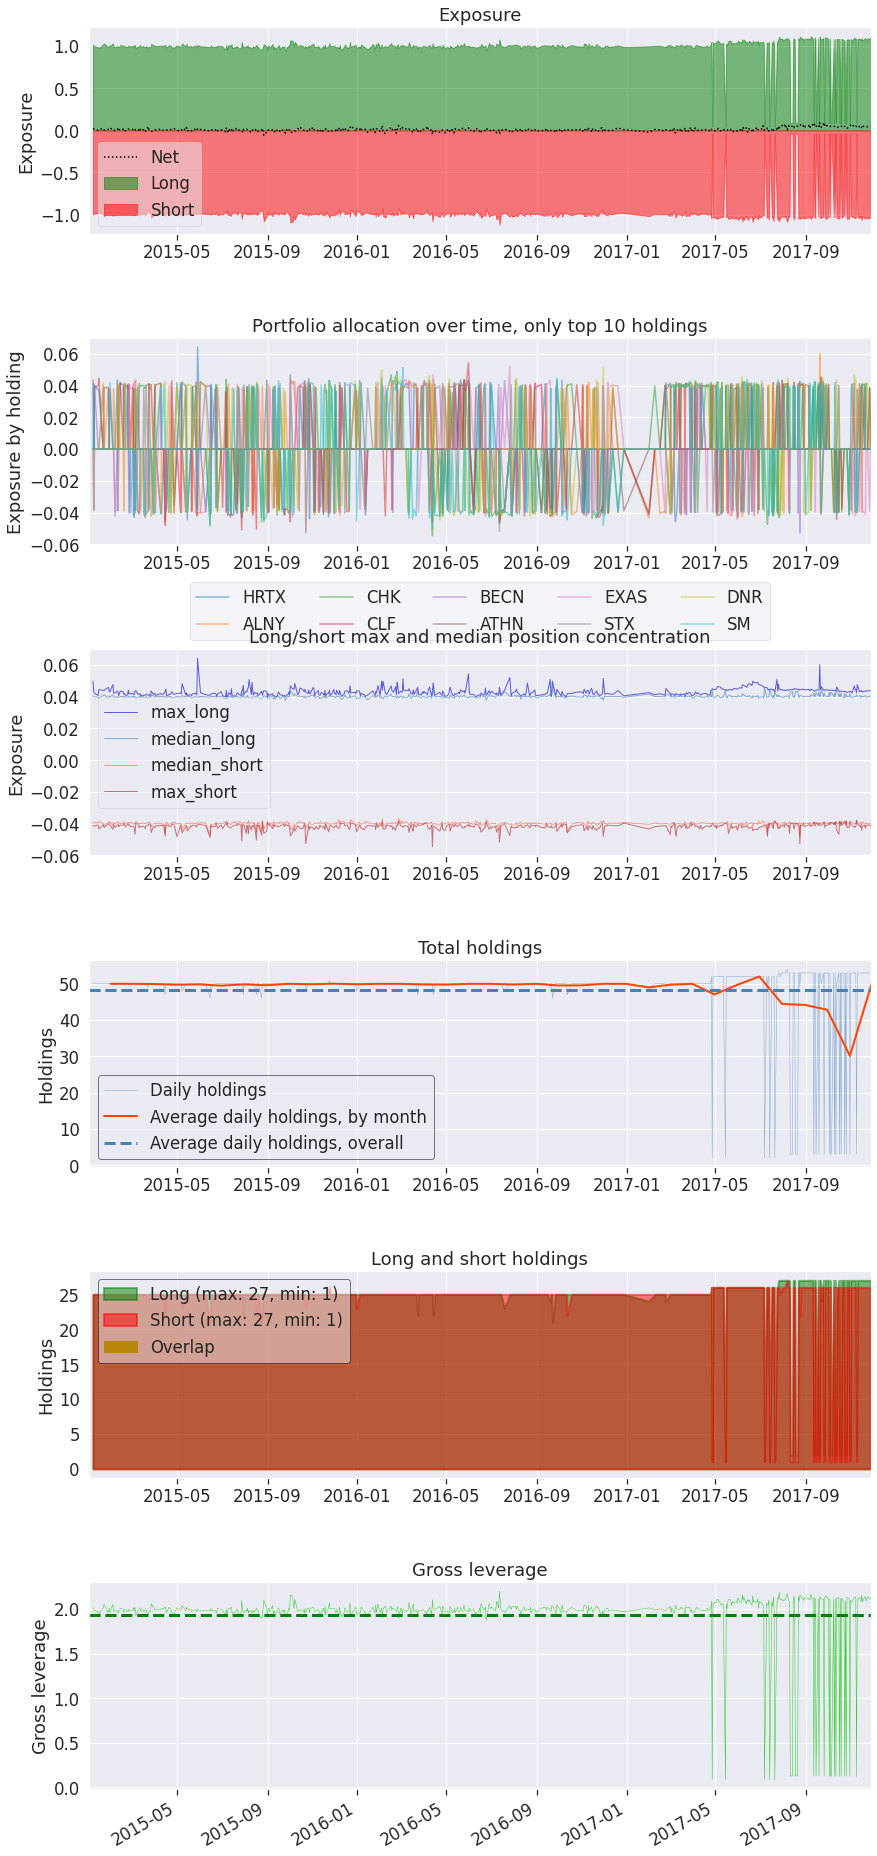

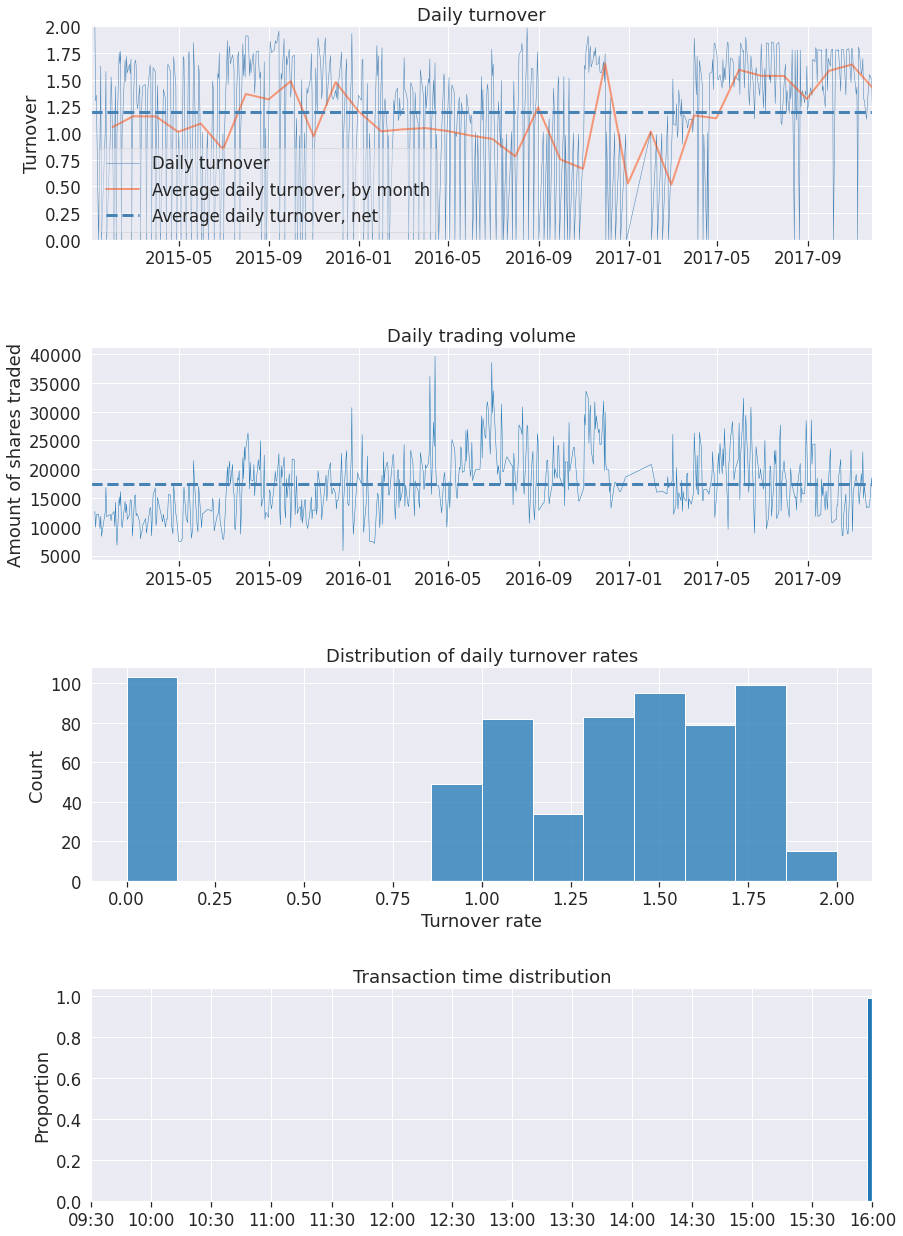

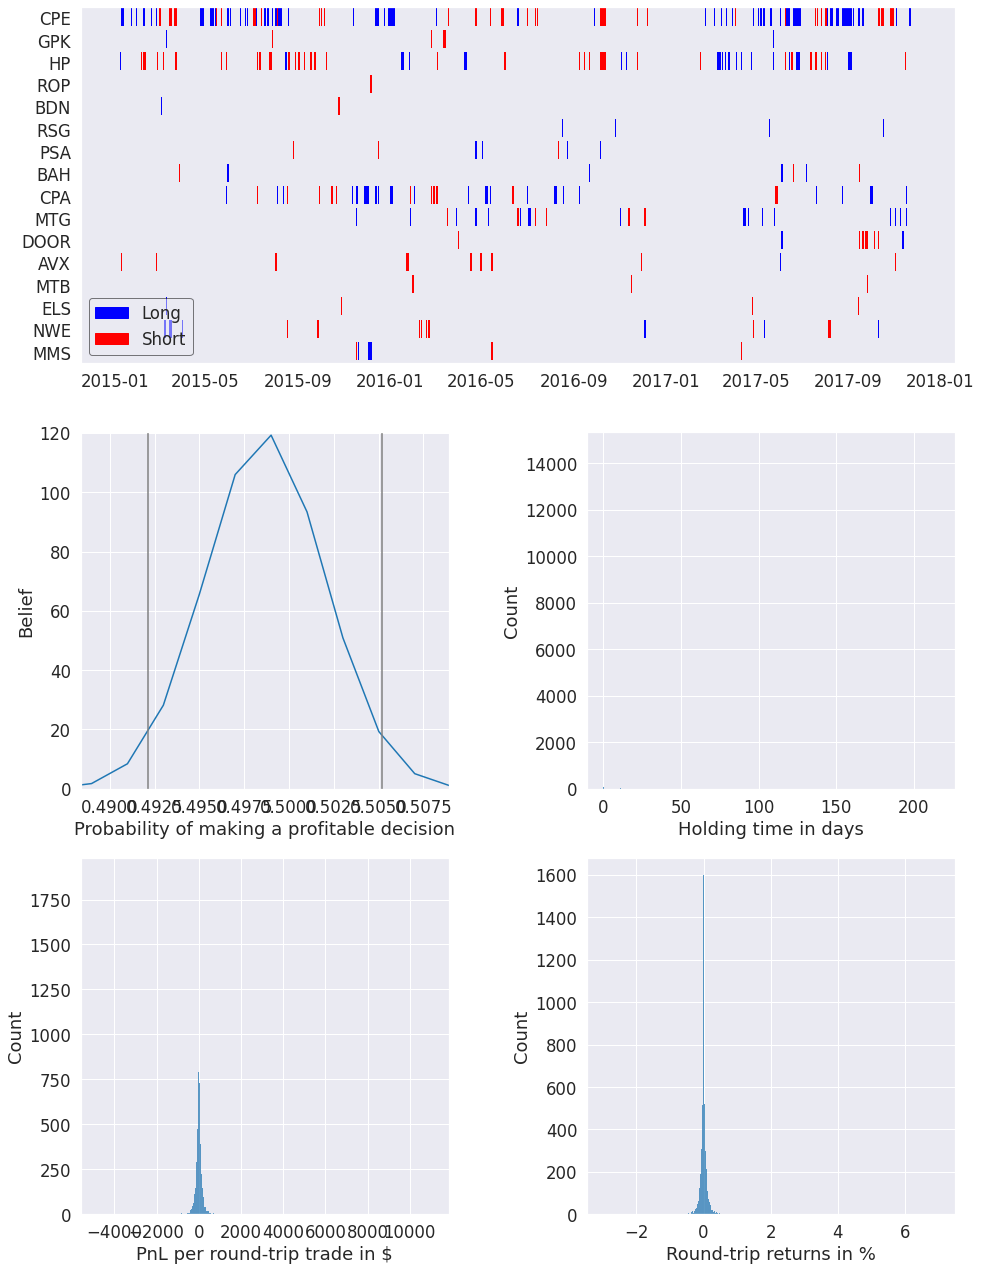

In [ ]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2017-01-01', 
                          round_trips=True)